In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import time
import pickle
import itertools

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 12
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
training_data = '/content/drive/MyDrive/Colab Notebooks/Colab Data/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(training_data, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [4]:
print('Dataset size:', len(df))
df.head(5)

Dataset size: 1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
  return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 485 ms, sys: 3.44 ms, total: 488 ms
Wall time: 494 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

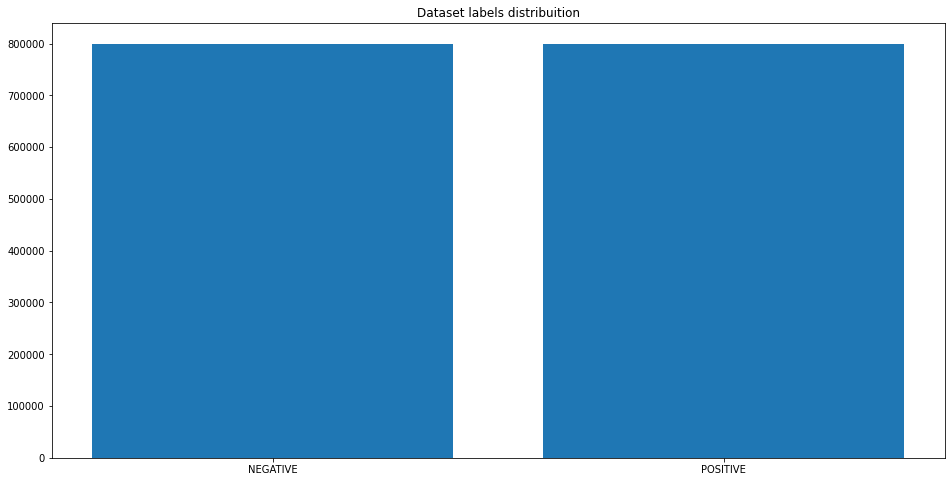

In [7]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [18]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [40]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    return text

In [41]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 7.02 s, sys: 172 ms, total: 7.19 s
Wall time: 7.22 s


In [42]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [43]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.68 s, sys: 441 ms, total: 3.12 s
Wall time: 3.11 s


In [44]:
w2v_model = gensim.models.word2vec.Word2Vec(size=120, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [45]:
w2v_model.build_vocab(documents)

2022-06-16 13:52:49,262 : INFO : collecting all words and their counts
2022-06-16 13:52:49,266 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-16 13:52:49,289 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-06-16 13:52:49,312 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-06-16 13:52:49,335 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-06-16 13:52:49,359 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-06-16 13:52:49,383 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-06-16 13:52:49,407 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-06-16 13:52:49,431 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2022-06-16 13:52:49,455 : INFO : PROGRESS: at s

In [46]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [47]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-06-16 13:52:58,533 : INFO : training model with 8 workers on 30369 vocabulary and 120 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-06-16 13:52:59,625 : INFO : EPOCH 1 - PROGRESS: at 4.13% examples, 317016 words/s, in_qsize 12, out_qsize 3
2022-06-16 13:53:00,683 : INFO : EPOCH 1 - PROGRESS: at 8.36% examples, 322780 words/s, in_qsize 13, out_qsize 4
2022-06-16 13:53:01,725 : INFO : EPOCH 1 - PROGRESS: at 12.38% examples, 320673 words/s, in_qsize 14, out_qsize 4
2022-06-16 13:53:02,806 : INFO : EPOCH 1 - PROGRESS: at 16.92% examples, 327957 words/s, in_qsize 15, out_qsize 0
2022-06-16 13:53:03,877 : INFO : EPOCH 1 - PROGRESS: at 20.92% examples, 323121 words/s, in_qsize 15, out_qsize 0
2022-06-16 13:53:04,890 : INFO : EPOCH 1 - PROGRESS: at 24.94% examples, 323539 words/s, in_qsize 15, out_qsize 1
2022-06-16 13:53:05,895 : INFO : EPOCH 1 - PROGRESS: at 28.94% examples, 324157 words/s, in_qsize 14, out_qsize 1
2022-06-16 13:53:06,957 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 19min 11s, sys: 6.82 s, total: 19min 18s
Wall time: 10min 18s


(263126762, 295270528)

In [48]:
w2v_model.most_similar("love")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2022-06-16 14:03:17,331 : INFO : precomputing L2-norms of word weight vectors


[('adore', 0.6716060638427734),
 ('loves', 0.6455568075180054),
 ('luv', 0.6419321298599243),
 ('loved', 0.6197524666786194),
 ('looove', 0.6081500053405762),
 ('loooove', 0.5888406038284302),
 ('amazing', 0.5709539651870728),
 ('loveee', 0.5574404001235962),
 ('sings', 0.5261883735656738),
 ('lovee', 0.5181275606155396)]

In [49]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 17.5 s, sys: 127 ms, total: 17.7 s
Wall time: 17.6 s


In [50]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=120)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=120)

CPU times: user 23.4 s, sys: 479 ms, total: 23.8 s
Wall time: 23.8 s


In [51]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [52]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [53]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 120)
y_train (1280000, 1)

x_test (320000, 120)
y_test (320000, 1)


In [54]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [55]:
embedding_matrix = np.zeros((vocab_size, 120))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 120)


In [56]:
embedding_layer = Embedding(vocab_size, 120, weights=[embedding_matrix], input_length=120, trainable=False)

In [57]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 120)          34850280  
                                                                 
 dropout_1 (Dropout)         (None, 120, 120)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                34200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 34,884,531
Trainable params: 34,251
Non-trainable params: 34,850,280
_________________________________________________________________


In [58]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [59]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
 302/1125 [=======>......................] - ETA: 23:22 - loss: 0.6053 - accuracy: 0.6647

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=120)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love this world")

In [ ]:
predict("I do enjoy my life")

In [ ]:
predict("I love mathematics")

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
model.save_weights('model_weights.h5')
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)